In [ ]:
from astropy.table import Table
import matplotlib.pyplot as plt

from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation, add_pulsation, evaluate_pulsations
import jax.numpy as jnp
from transformer_payne import Blackbody, TransformerPayne
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

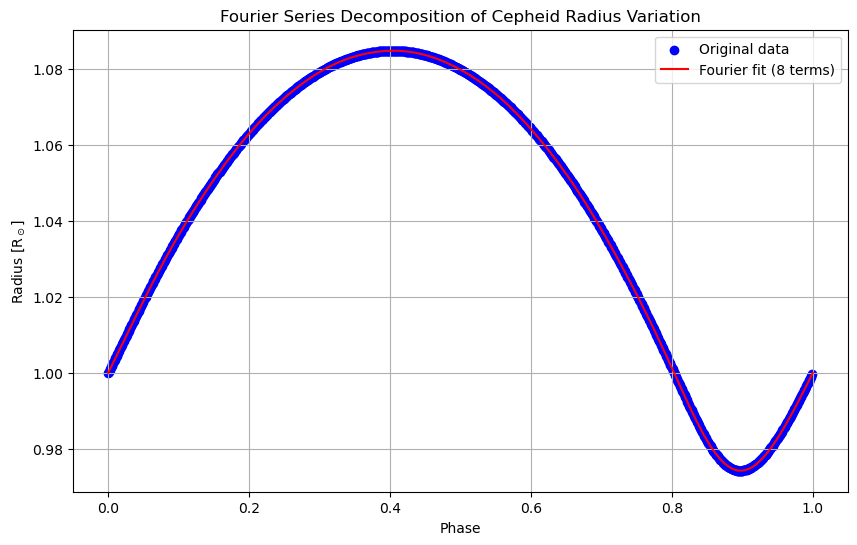

Mean radius (a0): 1.0420 R_sun
Fourier coefficients:
Term 1: amplitude = 0.0508, phase = 2.5278 rad
Term 2: amplitude = 0.0108, phase = 1.8932 rad
Term 3: amplitude = 0.0036, phase = 1.2427 rad
Term 4: amplitude = 0.0014, phase = 0.5484 rad
Term 5: amplitude = 0.0006, phase = -0.2436 rad
Term 6: amplitude = 0.0003, phase = -1.1542 rad
Term 7: amplitude = 0.0002, phase = -2.1086 rad
Term 8: amplitude = 0.0001, phase = -3.0076 rad

Fourier series parameters for SPICE:
[[ 5.08410023e-02  2.52778534e+00]
 [ 1.07786710e-02  1.89320108e+00]
 [ 3.64884277e-03  1.24266937e+00]
 [ 1.44494986e-03  5.48410078e-01]
 [ 6.17318686e-04 -2.43612157e-01]
 [ 2.88661671e-04 -1.15420866e+00]
 [ 1.52119818e-04 -2.10861958e+00]
 [ 8.50754672e-05 -3.00762780e+00]]


In [5]:
b = Blackbody()
model_data = Table.read('delta_cep.fits', format='fits', hdu=1)
pulsation_data = Table.read('delta_cep.fits', format='fits', hdu=2)

from collections import defaultdict

obs_phases = defaultdict(list)
obs_magnitudes = defaultdict(list)
obs_magnitudes_err = defaultdict(list)
obs_colors = defaultdict(list)
obs_colors_err = defaultdict(list)

for r in model_data:
    if 'mag' in r['OBS']:
        filter = r['OBS'].split('|')[1]
        obs_phases[filter].append(r['PHASE'])
        obs_magnitudes[filter].append(r['MEAS'])
        obs_magnitudes_err[filter].append(r['ERR'])
    if 'color' in r['OBS']:
        filter = r['OBS'].split('|')[1]
        obs_phases[filter].append(r['PHASE'])
        obs_colors[filter].append(r['MEAS'])
        obs_colors_err[filter].append(r['ERR'])
        
import numpy as np
def mjd_to_phase(mjd):
    """
    Convert MJD to phase using the period and reference epoch from model_data.
    
    Parameters
    ----------
    mjd : float or array-like
        Modified Julian Date(s) to convert to phase
        
    Returns
    -------
    float or array-like
        Phase(s) corresponding to the input MJD(s)
    """
    period = model_data['PERIOD'][0]  # Get period from model data
    ref_epoch = model_data['REF_EPOCH'][0]  # Get reference epoch from model data
    
    # Calculate phase using the formula: (MJD - ref_epoch) / period
    phase = (mjd - ref_epoch) / period
    
    # Normalize phase to be between 0 and 1
    phase = phase - np.floor(phase)
    
    return phase

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Extract radius and phase data
radius = np.array(pulsation_data['R']/pulsation_data['R'][0])
phases = np.array(pulsation_data['PHASE'])

# Sort data by phase to ensure proper fitting
sort_idx = np.argsort(phases)
phases = phases[sort_idx]
radius = radius[sort_idx]

# Define the Fourier series function
def fourier_series(x, a0, *args):
    """
    Fourier series function with a0 as the mean and args as pairs of (a_n, b_n) coefficients.
    """
    n_terms = len(args) // 2
    result = a0
    for i in range(n_terms):
        a_i = args[2*i]
        b_i = args[2*i+1]
        result += a_i * np.cos(2 * np.pi * (i+1) * x) + b_i * np.sin(2 * np.pi * (i+1) * x)
    return result

# Fit the Fourier series to the radius data
# Start with 4 terms (8 parameters + a0)
n_terms = 8
initial_guess = [np.mean(radius)] + [0.0] * (2 * n_terms)
params, params_covariance = optimize.curve_fit(fourier_series, phases, radius, p0=initial_guess)

# Extract the fitted parameters
a0 = params[0]
fourier_coeffs = params[1:]

# Prepare for visualization
phase_fine = np.linspace(0, 1, 1000)
radius_fit = fourier_series(phase_fine, *params)

# Plot the original data and the Fourier fit
plt.figure(figsize=(10, 6))
plt.scatter(phases, radius, color='blue', label='Original data')
plt.plot(phase_fine, radius_fit, color='red', label=f'Fourier fit ({n_terms} terms)')
plt.xlabel('Phase')
plt.ylabel('Radius [R$_\odot$]')
plt.title('Fourier Series Decomposition of Cepheid Radius Variation')
plt.legend()
plt.grid(True)
plt.show()

# Print the Fourier coefficients
print(f"Mean radius (a0): {a0:.4f} R_sun")
print("Fourier coefficients:")
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    print(f"Term {i+1}: amplitude = {amplitude:.4f}, phase = {phase:.4f} rad")

# Convert to format needed for SPICE pulsation model
# For SPICE, we need [amplitude, phase] pairs
fourier_series_parameters = np.zeros((n_terms, 2))
for i in range(n_terms):
    a_i = fourier_coeffs[2*i]
    b_i = fourier_coeffs[2*i+1]
    amplitude = np.sqrt(a_i**2 + b_i**2)
    phase = np.arctan2(b_i, a_i)
    fourier_series_parameters[i] = [amplitude, phase]

print("\nFourier series parameters for SPICE:")
print(fourier_series_parameters)

period = 5.366265401100268 #*24*60*60

In [6]:
import astropy.units as u

mb = IcosphereModel.construct(1000, np.mean(pulsation_data['R']), 5.26, b.to_parameters(dict(T=pulsation_data['Teff'][0])), b.parameter_names,
                              max_fourier_order=10,
                              max_pulsation_mode=10)

mb_p = add_pulsation(mb, m_order=0, l_degree=0, period=period, fourier_series_parameters=fourier_series_parameters)
timeseries = jnp.linspace(0, period, 20)

mb_ps = [evaluate_pulsations(mb_p, t) for t in tqdm(timeseries, desc='Evaluating model with a blackbody model')]

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


In [ ]:
phases = (timeseries / period) % 1.0

def mean_radius(model):
    return np.mean(np.linalg.norm(model.centers[model.mus>0], axis=1))

mean_radii = np.array([mean_radius(m) for m in mb_ps])

# Interpolate the mean radii to match the data points
from scipy.interpolate import interp1d

# Create interpolation function
interp_1d = interp1d(phases[:-1], mean_radii[:-1], kind='cubic', fill_value='extrapolate')

# Interpolate to get radius values at the same phases as the data
interpolated_radii = interp_1d(pulsation_data['PHASE'])


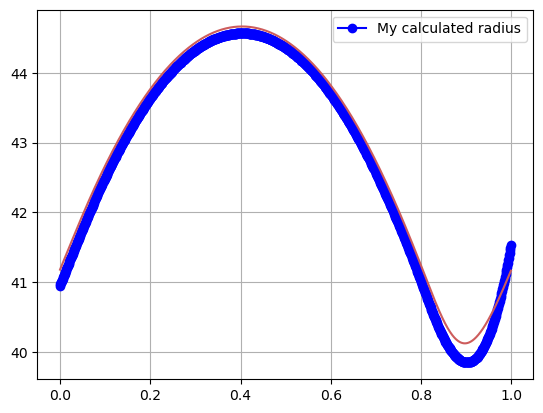

In [ ]:
# Plot the mean radius from my calculated data
plt.plot(pulsation_data['PHASE'], interpolated_radii, 'o-', color='blue', label='My calculated radius')
plt.legend()


plt.plot(pulsation_data['PHASE'], pulsation_data['R'], color='indianred')
plt.grid(True)

In [13]:
def chisq(model, data):
    return np.sum((model - data)**2 / data)

In [20]:
chisq(interpolated_radii, pulsation_data['R'])

0.6956503271210854

In [25]:
def model_for_R(r0):
    mb = IcosphereModel.construct(1000, r0, 5.26, b.to_parameters(dict(T=pulsation_data['Teff'][0])), b.parameter_names,
                                max_fourier_order=10,
                                max_pulsation_mode=10)

    mb_p = add_pulsation(mb, m_order=0, l_degree=0, period=period, fourier_series_parameters=fourier_series_parameters)
    timeseries = jnp.linspace(0, period, 20)

    mb_ps = [evaluate_pulsations(mb_p, t) for t in tqdm(timeseries, desc='Evaluating model with a blackbody model')]
    
    mean_radii = np.array([mean_radius(m) for m in mb_ps])

    # Create interpolation function
    interp_1d = interp1d(phases[:-1], mean_radii[:-1], kind='cubic', fill_value='extrapolate')

    # Interpolate to get radius values at the same phases as the data
    interpolated_radii = interp_1d(pulsation_data['PHASE'])
    
    c = chisq(interpolated_radii, pulsation_data['R'])
    print('R' + str(r0) + ' chisq' + str(c))
    return c

In [26]:
from scipy.optimize import minimize

# Minimize the function starting from the mean radius of the data
result = minimize(model_for_R, np.mean(pulsation_data['R']), method='Nelder-Mead')
print(f"Optimal base radius: {result.x[0]:.2f}")
print(f"Minimum chi-squared: {result.fun:.2f}")

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".j

R[42.909176] chisq0.6956503271210854


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[45.054634] chisq92.03857379482807


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[40.763718] chisq122.37397244416904


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.981903] chisq19.7383787806943


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[41.83645] chisq34.90803437067526


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.44554] chisq3.56058875325537


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[42.37281] chisq11.145288065212053


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.17736] chisq0.46373060445353165


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.445545] chisq3.5600839292461988


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.043266] chisq0.16358755816675066


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[42.909172] chisq0.6956819863026451


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.110313] chisq0.2095266023060698


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[42.97622] chisq0.32561627745709276


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.07679] chisq0.1605863818781049


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.110313] chisq0.2095266023060698


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.060028] chisq0.15558520928796316


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.043266] chisq0.16358755816675066


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.06841] chisq0.15646353292673681


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.051647] chisq0.15794900611062535


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.064217] chisq0.15561777792827558


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.05584] chisq0.15637256759044688


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.062122] chisq0.15550025532208334


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.064217] chisq0.15561777792827558


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.061073] chisq0.15551851035216718


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.06317] chisq0.1555339232581621


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.0616] chisq0.15550039189106935


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.062645] chisq0.15550799550013772


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.06186] chisq0.15550217077123774


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.06186] chisq0.15550217077123774


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.062386] chisq0.15550130815127589


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.062256] chisq0.15550143018223805


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.06199] chisq0.15549408973110115


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


R[43.061855] chisq0.15550157842846135


Evaluating model with a blackbody model: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]

R[43.062057] chisq0.15549955081111624
Optimal base radius: 43.06
Minimum chi-squared: 0.16
